In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os

import utilities

In [4]:
import urllib

txt_url = 'https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt'
txt_local = os.path.join('data', 'irish-lyrics', 'irish-lyrics-eof.txt')

if not os.path.exists(txt_local):
    urllib.request.urlretrieve(txt_url, txt_local)

In [5]:
with open(txt_local, 'r') as file:
    txt = [l for l in file]
    
print(f'There are {len(txt)} sentences.')

There are 1692 sentences.


In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(txt)
vocab_size = len(tokenizer.word_index) + 1
print(f'There are {vocab_size} words.')

There are 2690 words.


In [7]:
seqs = tokenizer.texts_to_sequences(txt)
subseqs = sum(([sq[:end+1] for end in range(1, len(sq))] for sq in seqs), start=[])
maxlen = max(len(sq) for sq in seqs)
padseqs = pad_sequences(subseqs, padding='pre', maxlen=maxlen, truncating='pre')
padseqs.shape

(12038, 16)

In [41]:
trn_size = 10000
trn_ind = np.random.choice(len(padseqs), size=trn_size, replace=False)
trn_b = np.zeros([len(padseqs)], dtype=bool)
trn_b[trn_ind] = True
trn_sq, val_sq = padseqs[trn_b, :-1], padseqs[~trn_b, :-1]
trn_lb, val_lb = padseqs[trn_b, -1], padseqs[~trn_b, -1]

trn_sq.shape, val_sq.shape

((10000, 15), (2038, 15))

In [40]:
def fit_lyric_pred(embed_d=16, hidden_d=16, lr=0.01, epochs=50, batch=64):
    ly = keras.layers
    model = keras.models.Sequential([
        ly.Embedding(vocab_size, embed_d),
        ly.Bidirectional(ly.LSTM(hidden_d)),
        ly.Dropout(0.5),
        ly.Dense(vocab_size, activation='softmax')
    ])
    model.summary()
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    history = model.fit(
        trn_sq, trn_lb,
        epochs=epochs, batch_size=batch,
        validation_data=(val_sq, val_lb)
    )
    
    utilities.plot_train_val_metrics(history, ['loss', 'accuracy'])
    
    return model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 16)          43040     
                                                                 
 bidirectional_8 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 2690)              88770     
                                                                 
Total params: 136,034
Trainable params: 136,034
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
157/157 [==============================] - 4s 13ms/step - loss: 6.7642 - accuracy: 0.0648 - val_loss: 6

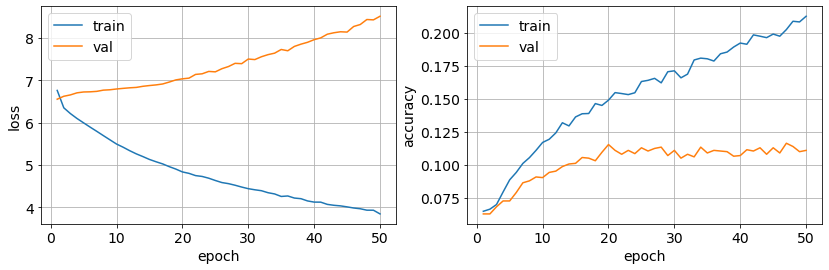

In [42]:
%%time
model = fit_lyric_pred()

In [21]:
def next_n_words(model, seedtxt, n=1, top=1, tokenizer=tokenizer):
    sqs = tokenizer.texts_to_sequences([seedtxt])
    sqs = pad_sequences(sqs, padding='pre', maxlen=maxlen, truncating='pre')
    words = []
    for _ in range(n):
        prob = model.predict(sqs, verbose=0)[0]
        heap = utilities.Heap(enumerate(prob), get_value=lambda x: x[1])
        k = np.random.choice(top) + 1
        for _ in range(k):
            item = heap.pop()
        sqs[0] = *sqs[0, 1:], item[0]
        words.append(tokenizer.index_word[item[0]])
        
    return words

In [43]:
seedtxt = 'help me obi-wan kinobi youre my only hope'
words = next_n_words(model, seedtxt, n=100, top=1)
print(' '.join(words))
print('')
print(' '.join(next_n_words(model2, seedtxt, n=100, top=3)))

town and and fast and the day they i love i all the old of the old woman did say the old of the banks of the green ones the green silver the blue banks town of the green ones the green day the green morning town of the old old sea fair morning town of and in the old on the green girl the sea the night of the sea is the world and the green we to the the green the sea fair of the crossroads i was in the pale broad woman above as i was in

has in in my own native mother against the sinking o so i wind from here from someone my bride my bride gone my i love i i found to me my love and i said no more love love i love more someone gone i love an i had i i love easy my love you love more love so i sinking love my eyes twinkle my eyes i sinking mccarthy gone wind i love love my love a moonshiny stuff gone and i am goes from my smile from my bride my love so love my love you


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 100)         269000    
                                                                 
 bidirectional_9 (Bidirectio  (None, 300)              301200    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_9 (Dense)             (None, 2690)              809690    
                                                                 
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
157/157 [==============================] - 3s 11ms/step - loss: 6.7141 - accuracy: 0.0665 - val_los

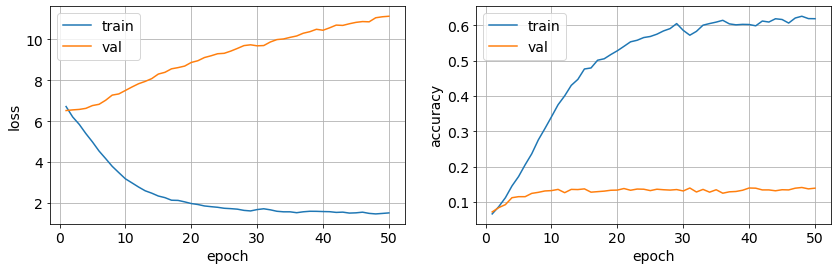

In [44]:
%%time
model2 = fit_lyric_pred(embed_d=100, hidden_d=150)

In [45]:
print(' '.join(next_n_words(model2, seedtxt, n=100, top=1)))
print('')
print(' '.join(next_n_words(model2, seedtxt, n=100, top=3)))

in the sea is the month of may wind gone love gone and love the love gone and love love gone and gone and right eyes and right sinking love gone right right in the town of right sinking love gone love gone and love the right love in love love gone and right eyes on sinking right gone and love gone and love gone and gone and right eyes and love right right in the right eyes and love right eyes on gone and love and gone and love gone love gone and right eyes on your eyes love

in erin my dear little town they may steer eyes there wind right gone in here gone by the sinking funds when love gone gone gone and love love here in bowlin your eyes part eyes this love the right sinking both gone of love and gone in gone and love love here gone love love the right sinking funds now love right sinking right gone in right gone in this right eyes on gone by love here love sinking funds when gone gone and sinking funds love sinking love the love wind unseen wind nor rain gone and now
